<h1 align="center" style="color:green;font-size: 3em;">Homework 2:
Implementing Fine-tuning Techniques</h1>



# Part 1: Introduction

In this homework, you will implement various fine-tuning methods as described in different papers, specifically LoRA and IA3, and answer some conceptual questions about these techniques. Additionally, you will get an introduction to Hugging Face, a platform offering a wide range of models and datasets.

**Instructions:**
- Follow the notebook sections to implement various fine-tuning techniques.
- Complete the code cells marked with `TODO`.
- Ensure your code runs correctly by the end of the notebook.

# Part 2: Import Libraries

In [1]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00


In [2]:
# importing required libraries
import torch
import torch.nn as nn
import collections
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

from torch.optim import AdamW
from typing import List
from torch.nn import functional as F
from tqdm import tqdm
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
)
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, T5Tokenizer, T5ForSequenceClassification
from torch.utils.data import DataLoader

warnings.simplefilter("ignore")
print(torch.__version__)

2.4.1+cu121


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Part 3: Import and Evaluate Models

In this homework, there are two main types of models: causal models and sequence classification models. The primary difference between them lies in their applications and functionality.
<hr>

<h3><strong>Causal Models</strong></h3>

Causal models, also known as autoregressive models, generate the next word in a sequence based on the preceding words. They are used for tasks such as text generation, language modeling, machine translation, and speech recognition. These models operate unidirectionally, predicting the next token using only previous tokens.


<h3><strong>Sequence Classification Models</strong></h3>

Sequence classification models categorize a given input sequence into predefined categories. They are useful for tasks like sentiment analysis, spam detection, topic classification, named entity recognition (NER), and document classification. These models often process the entire input sequence at once, using context from all tokens to make a classification decision.

## 3.1 Causal Model

First, we will initialize a causal model, specifically OPT-125m. When initializing a model, it is important to also initialize the corresponding tokenizer, as it handles the preprocessing of text data into a format that the model can understand. You can learn more about the OPT-125m model and its capabilities [here](https://huggingface.co/facebook/opt-125m).
<hr>
<h3>Task:</h3>

First, import the causal model we are using and call it `causal_model`. Next, import the for the model and call it `causal_tokenizer`

```
Code Hint:
The model name should be "facebook/opt-125m".
```

```
Code Hint:
Remember to put the model in GPU.
```


In [4]:
device

'cuda'

In [5]:
# TODO: Import the causal model
causal_model_name = "facebook/opt-125m"
causal_model = AutoModelForCausalLM.from_pretrained(causal_model_name).to(device)

# TODO: Import the tokenizer
causal_tokenizer = AutoTokenizer.from_pretrained(causal_model_name)

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Our dataset for this task is Wikitext, which is a collection of articles from Wikipedia. This dataset is widely used for language modeling and text generation tasks because of its comprehensive and diverse range of topics. You can read more about the Wikitext dataset and its features [here](https://huggingface.co/datasets/Salesforce/wikitext).

In [6]:
# Import wikitext dataset
causal_test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
causal_test_encodings = causal_tokenizer("\n\n".join(causal_test["text"]), return_tensors="pt")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Next, we will evaluate our model's effectiveness on the Wikitext dataset, an industry-standard benchmark for language modeling tasks. We will use perplexity to assess how well our model generates text.

Perplexity measures how well a language model predicts the next word in a sequence. It is calculated as the exponentiated average negative log-likelihood of a sequence. A lower perplexity score indicates better performance, meaning the model is more accurate and confident in its predictions. Perplexity is a standard metric for comparing models and evaluating their ability to generate natural-sounding text. For more details on perplexity, read [here](https://huggingface.co/docs/transformers/en/perplexity).

<hr>
<h3>Task: </h3>

Implement the `calc_perplexity` method which calculates the perplexity as described in the above article.


In [7]:
# TODO: Implement the method to calculate the perplexity
def calc_perplexity(model, encodings, stride):
    # model: our pretrained language model that we are evaluating on
    # encodings: input encodings containing input_ids and other relevant attributes
    # stride: the step size for segmenting the input sequence

    # Define max_length and seq_len
    max_length = model.config.max_position_embeddings
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    # Loop through the sequence with the given stride
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        # Ensure no gradients are calculated (hint: use torch.no_grad())
        with torch.no_grad():
            # Get the model outputs (hint: pass input_ids and labels to model)
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    # Return the perplexity (hint: exponentiate the average negative log likelihood)
    return torch.exp(torch.stack(nlls).mean())


After finishing the method, run the cell below. You should be getting around `25` as the final perplexity.

**Note:** This cell may take 1-2 minutes to run.

In [ ]:
## Calculate the perplexity of our causal model
calc_perplexity(causal_model, causal_test_encodings, 256)

 99%|█████████▉| 1116/1124 [05:03<00:02,  3.67it/s]


tensor(23.6299, device='cuda:0')

## 3.2 Sequence Classification Model

For sequence classification tasks, we will use T5-small, a model developed by Google and one of the more popular options available on Hugging Face. T5-small is a member of the T5 (Text-to-Text Transfer Transformer) family, which includes other models like T5-base and T5-large. While T5-small is efficient and suitable for many tasks, the larger models in this family offer more capacity and may provide improved performance but require significantly more computational resources and time for training and inference. Read more about T5-small [here](https://huggingface.co/google-t5/t5-small).

<hr>
<h3>Task:</h3>


First, import the sequence model we are using and call it `seq_model`. Next, import the for the model and call it `seq_tokenizer`.


```
Code Hint:
The model name should be "t5-small".
```

```
Code Hint:
Remember to put the model in GPU.
```

In [37]:
# TODO: Import the sequence model
seq_model_name = "t5-small"
seq_model = T5ForSequenceClassification.from_pretrained(seq_model_name, num_labels=3).to(device)

# TODO: Import the tokenizer
seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The dataset we will be using is called CommitmentBank (CB). Each data point in this dataset consists of a premise, a hypothesis, and a label. The premise and hypothesis are both sentences, while the label is an integer from 0 to 2, indicating the relationship between the hypothesis and the premise in one of three categories: entailment, contradiction, or neutral.

A key difference between the CB dataset and the WikiText dataset is that the CB dataset requires manual cleaning and preprocessing. This means we need to ensure the data is properly formatted and any noise is removed before it can be used for training and evaluation.

In [38]:
# Load the cb dataset
# Input "y" for "Do you rish to run the custom code?"
cb_dataset = load_dataset('super_glue', 'cb')

In [39]:
cb_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 56
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 250
    })
})

<hr>
<h3>Task: </h3>

Write the preproces function in which the input is a single datapoint of the dataset. The output of the method should be a dictionary (hash map) of exactly 3 keys: `input_ids`, `attention_mask`, and `labels`.


```
Code Hint:
You will need to use the tokenizer to tokenize the input to the method.
```


```
Code Hint:
Set "max_length" = 512, "truncation" = True, "padding" = "max_length" for the tokenizer.
```

```
Code Hint:
You will need to delete unecessary keys.
```

In [40]:
# TODO: Finish this method
def preprocess_function(examples):
    # Put sentence1 and sentence2 in a tuple
    '''
    questions: tuple does not work
    '''
    inputs = (examples['premise'], examples['hypothesis'])
    #inputs = [f"{p}{h}" for p, h in zip(examples['premise'], examples['hypothesis'])]
    # Put the inputs inside a tokenizer
    result = seq_tokenizer(*inputs,
                           max_length=512,
                           truncation=True,
                           padding="max_length",
                           return_tensors="pt",
                           add_special_tokens=True)

    result['labels'] = torch.tensor(examples["label"])
    '''
    print(result["labels"].shape)
    print(result["input_ids"].shape)
    print(result["attention_mask"].shape)
    '''
    ## Delete unnecessary keys
    del examples["premise"]
    del examples['hypothesis']
    del examples["label"]
    del examples["idx"]
    return result


In [41]:
# Load cb's train and validation sets
seq_train_dataset = cb_dataset['train'].map(preprocess_function, batched=True)
seq_train_loader = DataLoader(seq_train_dataset, batch_size=8, shuffle=False)
print(f"There are {len(seq_train_dataset)} number of training examples")

seq_test_dataset = cb_dataset['validation'].map(preprocess_function, batched=True)
seq_test_loader = DataLoader(seq_test_dataset, batch_size=8, shuffle=False)
print(f"There are {len(seq_test_dataset)} number of validation examples")

There are 250 number of training examples


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

There are 56 number of validation examples


For sequence classification models, we don't usually use perplexity to calculate our performance. Instead, we calculate the accuracy of the model which is just the number of correct predictions / the number of total predictions.

<hr>
<h3> Task: </h3>

Complete the `calc_accuracy` method which takes in the model, the dataloader, and device so that it calculates the accuracy of the inputted model.


```
Code Hint:
To do inference on the model, it will need to take in the "input_ids", "attention_mask" and "labels".
```

In [44]:
def compute_accuracy(predictions, labels):
    preds = torch.argmax(predictions, dim=1).squeeze()
    labels = labels.squeeze()
    return (preds == labels).float().mean().item()

# TODO: Complete this method
def calc_accuracy(model, dataloader, device):

    model.eval()  # Set the model to evaluation mode
    accuracy = 0
    num_batches = 0


    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            # Move batch to device
            '''
            question: after dataloader processing, we get list of tneosrs rather than tensor, we have list of length 512, each element is tensor of length 8
            in each batch, but we need to have tensor of shape [8, 512]
            '''
            input_ids = torch.stack(batch["input_ids"], dim=0).transpose(0,1)
            attention_mask = torch.stack(batch["attention_mask"], dim=0).transpose(0,1)
            labels = batch["labels"]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            '''
            print(input_ids.shape)
            print(attention_mask.shape)
            print(labels.shape)
            '''
            # Forward pass through the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels = labels
            )

            accuracy = compute_accuracy(outputs.logits, labels)
            num_batches +=1

    # Compute overall accuracy
    accuracy = accuracy / num_batches
    return accuracy

Run the cell below to calculate the accuracy of the model.

In [45]:
final_accuracy = calc_accuracy(seq_model, seq_test_loader, device)
print(f"Final accuracy is {final_accuracy}")

Final accuracy is 0.05357142857142857


# Part 4: Full Fine-tuning

In this section, we are going to fine-tune our entire sequence classification model. The purpose of fine-tuning is to adapt a pre-trained model, like T5 from Hugging Face, to our specific task of CB. By using the pre-existing knowledge encoded in the model's weights, fine-tuning allows us to improve performance on CB-related tasks by adjusting these weights based on our dataset.


## 4.1 Setting Parameters as Trainable

First, we want to understand more about our model by making the parameters trainable and calculating the estimated GPU memory usage.

<hr>
<h3>Task: </h3>

Set every parameter in our model to be trainable and caluclate the total number of trainable parameters as well as an estimated GPU memory usage of the trainable parameters.


```
Code Hint:
The total number of trainable parameters should be around 60 million.
```

```
Code Hint:
The estimated GPU memory usage should be around 230 MB.
```

In [46]:
# TODO: Set every parameter in the model as trainable
model = seq_model
for param in model.parameters():
    param.requires_grad = True


In [48]:
# TODO: Calculate the number of trainable parameters
# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

60770819


In [50]:
# TODO: Calculate the estimated GPU memory usage in megabytes
mem_params = sum([p.nelement() * p.element_size() for p in model.parameters()])
mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
mem = mem_params + mem_bufs  # in bytes
mem_mb = mem / 1024**2  # Convert to MB
print(mem_mb)

231.8222770690918


## 4.2 Fine-tune Trainer Class

Next, we want to show how different learning rates affect our fine-tuning. To do so, please implement the methods inside our Trainer class so we can train and perform inference on our model.

<hr>
<h3>Task:</h3>

Implement the following methods inside the Trainer class:

`__init__`

- Initialize the model, learning rate, optimizer, device, and the loaders
- Run the `set_seed` method provided below


`train_one_epoch`

- Trains the model on the train loader for one epoch and returns the loss and accuracy of that epoch

`evaluate_one_epoch`

-  Evaluates the modle on the validation loader for one epoch and returns the loss and accuracy of that epoch

`train_and_evaluate`

- Trains and evaluates the model on multiple epochs

In [57]:
# TODO: Implement the trainer class
from sklearn.metrics import accuracy_score, classification_report

class Trainer:
    def __init__(self, model, train_loader, val_loader, learning_rate=1e-5, seed=42):

        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.learning_rate = learning_rate
        self.seed = seed


        self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)

        self.seed= seed
        self.set_seed()

    # Sets the seed
    def set_seed(self):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def train_one_epoch(self):

        self.model.train()
        total_loss = 0

        all_preds = []
        all_labels = []

        progress_bar = tqdm(self.train_loader, desc="Training")
        for batch in progress_bar:
            self.optimizer.zero_grad()



            input_ids = torch.stack(batch["input_ids"], dim=0).transpose(0,1)
            attention_mask = torch.stack(batch["attention_mask"], dim=0).transpose(0,1)
            labels = batch['labels'].to(self.device)

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(self.train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        return avg_loss, accuracy

    def evaluate_one_epoch(self):

        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Evaluating"):

                input_ids = torch.stack(batch["input_ids"], dim=0).transpose(0,1)
                attention_mask = torch.stack(batch["attention_mask"], dim=0).transpose(0,1)
                labels = batch['labels'].to(self.device)

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        report = classification_report(all_labels, all_preds)

        return avg_loss, accuracy, report

    def train_and_evaluate(self, num_epochs, verbose=True):

        best_accuracy = 0

        train_accuracies = []

        result_dict = {}


        result_dict["train_loss"] = []
        result_dict["train_accuracy"] = []
        result_dict["val_loss"] = []
        result_dict["val_accuracy"] = []

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")

            train_loss, train_accuracy = self.train_one_epoch()

            result_dict["train_loss"].append(train_loss)
            result_dict["train_accuracy"].append(train_accuracy)

            val_loss, val_accuracy, val_report = self.evaluate_one_epoch()

            result_dict["val_loss"].append(val_loss)
            result_dict["val_accuracy"].append(val_accuracy)

            if verbose:
                print(f"Train Loss: {train_loss:.4f}")
                print(f"Validation Loss: {val_loss:.4f}")
                print(f"Validation Accuracy: {val_accuracy:.4f}")
                print("Classification Report:")
                print(val_report)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(self.model.state_dict(), 'best_model.pth')
                print("New best model saved!")



        print(f"Best Validation Accuracy: {best_accuracy:.4f}")
        return result_dict

After finishing the Trainer class, train the different learning rates on 5 epochs each (let the seed be 42) and record the train losses, validation losses, train accuracies, and validation accuracies for each epoch.

In [58]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
epochs = 5
seed = 42
all_results = {}

for lr in learning_rates:
    trainer = Trainer(seq_model,
                      seq_train_loader,
                      seq_test_loader,
                      learning_rate=lr,
                      seed=seed)
    all_results[lr] = trainer.train_and_evaluate(num_epochs=epochs)

Epoch 1/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


Train Loss: 12.7631
Validation Loss: 5.3729
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

New best model saved!
Epoch 2/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


Train Loss: 17.8866
Validation Loss: 26.1512
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

Epoch 3/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


Train Loss: 23.2826
Validation Loss: 19.8508
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

Epoch 4/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


Train Loss: 11.7025
Validation Loss: 3.4479
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

Epoch 5/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


Train Loss: 12.8225
Validation Loss: 12.5267
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

Best Validation Accuracy: 0.5000
Epoch 1/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


Train Loss: 5.4577
Validation Loss: 2.6172
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

New best model saved!
Epoch 2/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


Train Loss: 2.7286
Validation Loss: 3.2229
Validation Accuracy: 0.0893
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        28
           2       0.09      1.00      0.16         5

    accuracy                           0.09        56
   macro avg       0.03      0.33      0.05        56
weighted avg       0.01      0.09      0.01        56

Epoch 3/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


Train Loss: 2.2380
Validation Loss: 1.5413
Validation Accuracy: 0.0893
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        28
           2       0.09      1.00      0.16         5

    accuracy                           0.09        56
   macro avg       0.03      0.33      0.05        56
weighted avg       0.01      0.09      0.01        56

Epoch 4/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


Train Loss: 2.2534
Validation Loss: 2.4563
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

New best model saved!
Epoch 5/5


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Train Loss: 1.5590
Validation Loss: 3.1801
Validation Accuracy: 0.4107
Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        23
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00         5

    accuracy                           0.41        56
   macro avg       0.14      0.33      0.19        56
weighted avg       0.17      0.41      0.24        56

Best Validation Accuracy: 0.5000
Epoch 1/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


Train Loss: 1.2357
Validation Loss: 1.4530
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

New best model saved!
Epoch 2/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


Train Loss: 1.5313
Validation Loss: 1.8781
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 3/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


Train Loss: 1.9293
Validation Loss: 1.1722
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 4/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


Train Loss: 1.5480
Validation Loss: 1.1869
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 5/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


Train Loss: 1.4590
Validation Loss: 1.4107
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Best Validation Accuracy: 0.5000
Epoch 1/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


Train Loss: 1.2342
Validation Loss: 1.0472
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

New best model saved!
Epoch 2/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


Train Loss: 1.0157
Validation Loss: 0.9630
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 3/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


Train Loss: 0.9612
Validation Loss: 0.9404
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 4/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


Train Loss: 0.9406
Validation Loss: 0.9352
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Epoch 5/5


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

Train Loss: 0.9368
Validation Loss: 0.9343
Validation Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.50      1.00      0.67        28
           2       0.00      0.00      0.00         5

    accuracy                           0.50        56
   macro avg       0.17      0.33      0.22        56
weighted avg       0.25      0.50      0.33        56

Best Validation Accuracy: 0.5000


In [59]:
all_results

{0.1: {'train_loss': [12.763097574170388,
   17.886571936083783,
   23.282638166099787,
   11.702491541906056,
   12.822527238018665],
  'train_accuracy': [0.472, 0.488, 0.508, 0.58, 0.564],
  'val_loss': [5.372896671295166,
   26.151175022125244,
   19.850849185671127,
   3.447911262512207,
   12.526679992675781],
  'val_accuracy': [0.5,
   0.4107142857142857,
   0.4107142857142857,
   0.4107142857142857,
   0.4107142857142857]},
 0.01: {'train_loss': [5.457711703836253,
   2.728638194814266,
   2.237957271747291,
   2.253376843611477,
   1.5590047359000891],
  'train_accuracy': [0.508, 0.468, 0.44, 0.528, 0.616],
  'val_loss': [2.617174676486424,
   3.2228545461382185,
   1.5413285834448678,
   2.4563443660736084,
   3.180074998310634],
  'val_accuracy': [0.4107142857142857,
   0.08928571428571429,
   0.08928571428571429,
   0.5,
   0.4107142857142857]},
 0.001: {'train_loss': [1.2357033732841955,
   1.5313491252018139,
   1.9292902485467494,
   1.548026956152171,
   1.45896100858226

## 4.3 Visualize Fine-tuning Results

Now, we want to see the results of what we fine-tuned by graphing the loss curve.

<hr>
<h3>Task: </h3>

Using the results from the previous section, generate a graph that has all the learning rate's training and validation loss values for each epoch. The graph should clearly illustrate the performance metrics across different learning rates for each epoch and have an appropriate title.

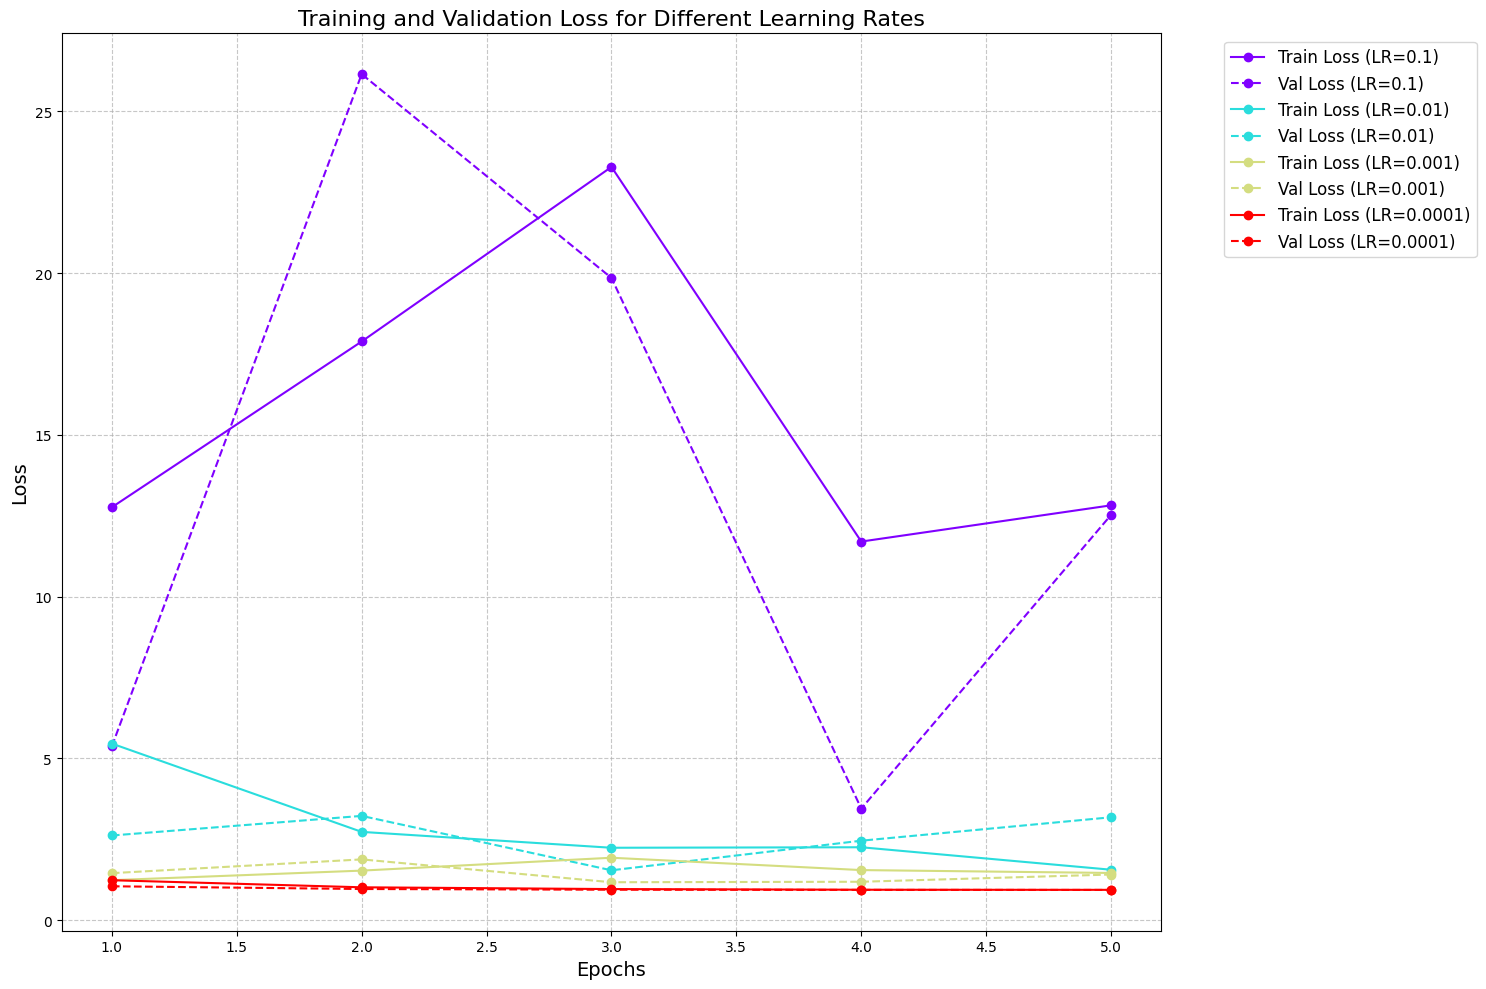

In [61]:
# TODO: Plot the loss curves

def plot_learning_rate_performance(results_dict):
    plt.figure(figsize=(15, 10))

    # Set up colors for each learning rate
    colors = plt.cm.rainbow(np.linspace(0, 1, len(results_dict)))

    for (lr, data), color in zip(results_dict.items(), colors):
        epochs = range(1, len(data['train_loss']) + 1)

        # Plot training loss
        plt.plot(epochs, data['train_loss'], '-o', color=color, label=f'Train Loss (LR={lr})')

        # Plot validation loss
        plt.plot(epochs, data['val_loss'], '--o', color=color, label=f'Val Loss (LR={lr})')

    plt.title('Training and Validation Loss for Different Learning Rates', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    #plt.savefig('learning_rate_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_rate_performance(all_results)

## 4.4 Conceptual Questions
**Question:** Why does the loss increase across the epochs for some of the learning rates?

  **Your Answer:**

  The reason is that the learning rate is too high, so the trainig result is not stable. We can use shceduler to adjust the learning rate during the training process to avoid unstability.